# Universal GNN Decoder for Different Codes

In this notebook, you will learn about graph neural network (GNN)-based decoding of BCH codes. 

This code is provided as supplementary material to the paper [[Graph Neural Networks for Channel Decoding]](https://arxiv.org/pdf/2207.14742.pdf). 
If you in any way use this code for research that results in publications, please cite it appropriately. 

This notebook is designed to be as flexible as possible and allows to load multiple codes.

This notebook requires [Sionna](https://nvlabs.github.io/sionna/).


In [1]:
from sionna.fec.utils import load_alist, alist2mat, load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils import BinarySource, ebnodb2no
from sionna.utils.metrics import compute_ber
from sionna.utils.plotting import PlotBER
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.channel import AWGN
from sionna.fec.ldpc import LDPCBPDecoder, LDPC5GEncoder, LDPC5GDecoder
from sionna.fec.polar import Polar5GEncoder, Polar5GDecoder, PolarEncoder, generate_5g_ranking
from sionna.fec.polar.utils import generate_dense_polar
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Layer

%load_ext autoreload
%autoreload 2
from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 1 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 1 used.


## Load Codes

We define all parameters as dictionary to support different architectures for different codes.


In [3]:
# Polar
params={
     # --- Code Parameters ---    
         "code": "Polar", # Remark: GNN parameters are not optimized for Polar codes!
         "n": 128,
         "k": 64,
     # --- GNN Architecture ----
        "num_embed_dims": 16,
        "num_msg_dims": 16,
        "num_hidden_units": 64,
        "num_mlp_layers": 2,
        "num_iter": 10,#10,
        "reduce_op": "mean",
        "activation": "tanh",# "tanh",
        "clip_llr_to": None,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "return_infobits": False,
        "use_bias": False,
     # --- Training ---- # 
         "batch_size": [128, 128, 128], # bs, iter, lr must have same dim
         "train_iter": [50000, 200000, 100000],
         "learning_rate": [1e-3, 1e-4, 1e-5],
         "ebno_db_train": [2.0, 4.],
         "ebno_db_eval": 2.,          
         "batch_size_eval": 1000,           
     # --- Log ----
         "save_weights_iter": 10000, # save weights every X iters
         "run_name": "Polar_01", # name of the stored weights
         "save_dir": "results/",
     # --- MC Simulation parameters ----
         "mc_iters": 100,
         "mc_batch_size": 1000,
         "num_target_block_errors": 500,
         "ebno_db_min": 0.,
         "ebno_db_max": 4.,
         "ebno_db_stepsize": 0.5,
         "eval_iters": [4, 6, 8, 10],
     # --- Weighted BP parameters ----
         "simulate_wbp": True, # simulate weighted BP as baseline
         "wbp_batch_size" : [1000, 1000, 1000],
         "wbp_train_iter" : [200, 1000, 1000],
         "wbp_learning_rate" : [1e-2, 1e-3, 1e-3],
         "wbp_ebno_train" : [5., 6., 7.],
         "wbp_ebno_val" : 5.,
         "wbp_batch_size_val" : 10000,
         "wbp_clip_value_grad" : 10, 
}

# -----WiFi LDPC-----
# Remark: Parameters for this code are not optimized
params={
     # --- Code Parameters ---
        "code": "LDPC", # load 802.11n LDPC code
     # --- GNN Architecture ----
        "num_embed_dims": 16,
        "num_msg_dims": 16,
        "num_hidden_units": 64, 
        "num_mlp_layers": 2,
        "num_iter": 10,
        "reduce_op": "mean",
        "activation": "tanh",
        "clip_llr_to": None,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "return_infobits": False,
        "use_bias": False,
     # --- Training ---- # 
         "batch_size": [128, 128, 128], # bs, iter, lr must have same dim
         "train_iter": [50000, 200000, 100000],
         "learning_rate": [1e-3, 1e-4, 1e-5],
         "ebno_db_train": [2.0, 4.],
         "ebno_db_eval": 2.,          
         "batch_size_eval": 1000,  
         "eval_train_steps": 1000, # evaluate model every N iters
     # --- Log ----
         "save_weights_iter": 10000, # save weights every X iters
         "run_name": "LDPC_01", # name of the stored weights
         "save_dir": "results/",
     # --- MC Simulation parameters ----
         "mc_iters": 100,
         "mc_batch_size": 1000,
         "num_target_block_errors": 500,
         "ebno_db_min": 0.,
         "ebno_db_max": 4.,
         "ebno_db_stepsize": 0.5,
         "eval_iters": [4, 6, 8, 10],
     # --- Weighted BP parameters ----
         "simulate_wbp": False, # simulate weighted BP as baseline
        "wbp_batch_size" : [1000, 1000, 1000],
         "wbp_train_iter" : [200, 2000, 2000],
         "wbp_learning_rate" : [1e-2, 1e-3, 1e-3],
         "wbp_ebno_train" : [5., 6., 7.],
         "wbp_ebno_val" : 5.,
         "wbp_batch_size_val" : 10000,
         "wbp_clip_value_grad" : 10, 
}

#----- BCH -----
params={
    # --- Code Parameters ---
        "code": "BCH", # (63,45)
    # --- GNN Architecture ----
        "num_embed_dims": 20,
        "num_msg_dims": 20,
        "num_hidden_units": 40,
        "num_mlp_layers": 2,
        "num_iter": 8,
        "reduce_op": "mean",
        "activation": "tanh",
        "clip_llr_to": 20.,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "use_bias": False,        
    # --- Training ---- # 
        "batch_size": [256, 256, 256], # bs, iter, lr must have same dim
        "train_iter": [100000, 100000, 100000],
        "learning_rate": [1e-3, 1e-4, 1e-5],
        "ebno_db_train": [3., 8.],
        "ebno_db_eval": 4.,          
        "batch_size_eval": 1000, # batch size only used for evaluation during training
        "eval_train_steps": 1000, # evaluate model every N iters
    # --- Log ----
        "save_weights_iter": 10000, # save weights every X iters
        "run_name": "BCH_01", # name of the stored weights/logs
        "save_dir": "results/",
    # --- MC Simulation parameters ----
        "mc_iters": 100,
        "mc_batch_size": 1000,
        "num_target_block_errors": 500,
        "ebno_db_min": 2.,
        "ebno_db_max": 9.,
        "ebno_db_stepsize": 0.5,
        "eval_iters": [4, 6, 8, 10],
        "simulate_wbp": False, # simulate weighted BP as baseline
    # --- Weighted BP parameters ----
        "wbp_batch_size" : [1000, 1000, 1000],
        "wbp_train_iter" : [200, 1000, 1000],
        "wbp_learning_rate" : [1e-2, 1e-3, 1e-3],
        "wbp_ebno_train" : [5., 6., 7.],
        "wbp_batch_size_val" : 10000,
        "wbp_clip_value_grad" : 10, 
}

## Load / Generate the Graph

Other code constructions can be implemented here. Please note that an encoder is required for the training (no all-zero codeword based training).

In [4]:
# all codes must provide an encoder-layer and a pcm
if params["code"]=="BCH":    
    print("Loading BCH code")
    pcm, k, n, coderate = load_parity_check_examples(pcm_id=1, verbose=True)

    encoder = LinearEncoder(pcm, is_pcm=True)
    params["k"] = k
    params["n"] = n

elif params["code"]=="LDPC": # load example code from 802.11n
    print("Loading LDPC")
    
    pcm, k, n, coderate = load_parity_check_examples(pcm_id=4, verbose=True)

    encoder = LinearEncoder(pcm, is_pcm=True)
    params["k"] = k
    params["n"] = n    

elif params["code"]=="Polar": # dense polar (no CRC)
    print("Loading 5G Polar code without CRC")
    print("Remark: this parity-check matrix is not made optimized for BP decoding!")
    k = params["k"]
    n = params["n"]

    f,_ = generate_5g_ranking(k,n)
    encoder = PolarEncoder(f, n)
    pcm, _= generate_dense_polar(f, n)
    
else:
    # you can also implement your own codes here
    raise ValueError("unknown code type")

Loading BCH code

n: 63, k: 45, coderate: 0.714


## Simulate Baseline BER Performance

In [20]:
ber_plot = PlotBER(f"GNN-based Decoding -- {params['code']}, (k,n)=({k},{n})")
ebno_dbs = np.arange(params["ebno_db_min"],
                     params["ebno_db_max"]+1,
                     params["ebno_db_stepsize"])

In [21]:
# uncoded QPSK
e2e_uncoded = E2EModel(None, None, k=100, n=100) # k and n are not relevant here
ber_plot.simulate(e2e_uncoded,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 3.8090e-02 | 9.8000e-01 |        3809 |      100000 |          980 |        1000 |         1.1 |reached target block errors
      2.5 | 2.9710e-02 | 9.5000e-01 |        2971 |      100000 |          950 |        1000 |         0.0 |reached target block errors
      3.0 | 2.3190e-02 | 9.0100e-01 |        2319 |      100000 |          901 |        1000 |         0.0 |reached target block errors
      3.5 | 1.6940e-02 | 8.0500e-01 |        1694 |      100000 |          805 |        1000 |         0.0 |reached target block errors
      4.0 | 1.3520e-02 | 7.4700e-01 |        1352 |      100000 |          747 |        1000 |         0.0 |reached target block errors
      4.5 | 8.9100e-03 | 6.0300e-01 |         891 |      100000 |

In [22]:
# simulate "conventional" BP performance for given pcm
bp_decoder = LDPCBPDecoder(pcm, num_iter=params["num_iter"], hard_out=False)
e2e_bp = E2EModel(encoder, bp_decoder, k, n)
ber_plot.simulate(e2e_bp,
                ebno_dbs=ebno_dbs,
                batch_size=params["mc_batch_size"],
                num_target_block_errors=params["num_target_block_errors"],
                legend=f"BP {bp_decoder._num_iter.numpy()} iter.",
                soft_estimates=True,
                max_mc_iter=params["mc_iters"],
                forward_keyboard_interrupt=False,
                show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.1048e-02 | 8.1300e-01 |        3846 |       63000 |          813 |        1000 |         1.7 |reached target block errors
      2.5 | 4.8206e-02 | 7.1200e-01 |        3037 |       63000 |          712 |        1000 |         0.0 |reached target block errors
      3.0 | 3.2873e-02 | 5.0500e-01 |        2071 |       63000 |          505 |        1000 |         0.0 |reached target block errors
      3.5 | 2.2357e-02 | 3.6300e-01 |        2817 |      126000 |          726 |        2000 |         0.0 |reached target block errors
      4.0 | 1.4392e-02 | 2.2533e-01 |        2720 |      189000 |          676 |        3000 |         0.0 |reached target block errors
      4.5 | 9.5119e-03 | 1.4950e-01 |        2397 |      252000 |

In [8]:
# train and simulate Weighted BP as additional baseline
# please note that the training parameters could be critical 
if params["simulate_wbp"]:
    evaluate_wbp(params, pcm, encoder, ebno_dbs, ber_plot)

### GNN-based Decoding


In [9]:
tf.random.set_seed(2)
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=True,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     use_bias=params["use_bias"])
                     
e2e_gnn = E2EModel(encoder, gnn_decoder, k, n)

In [ ]:
# init model and print summary
e2e_gnn(1, 1.)
e2e_gnn.summary()

In [ ]:
# and let's train the model
train_gnn(e2e_gnn, params)

## Evaluate Final Performance

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.0206e-02 | 8.4700e-01 |        3793 |       63000 |          847 |        1000 |         4.1 |reached target block errors
      2.5 | 4.6333e-02 | 7.2100e-01 |        2919 |       63000 |          721 |        1000 |         0.0 |reached target block errors
      3.0 | 3.2619e-02 | 5.6700e-01 |        2055 |       63000 |          567 |        1000 |         0.0 |reached target block errors
      3.5 | 2.3103e-02 | 4.4450e-01 |        2911 |      126000 |          889 |        2000 |         0.0 |reached target block errors
      4.0 | 1.4167e-02 | 3.0000e-01 |        1785 |      126000 |          600 |        2000 |         0.0 |reached target block errors
      4.5 | 7.9471e-03 | 1.8700e-01 |        1502 |      189000 |

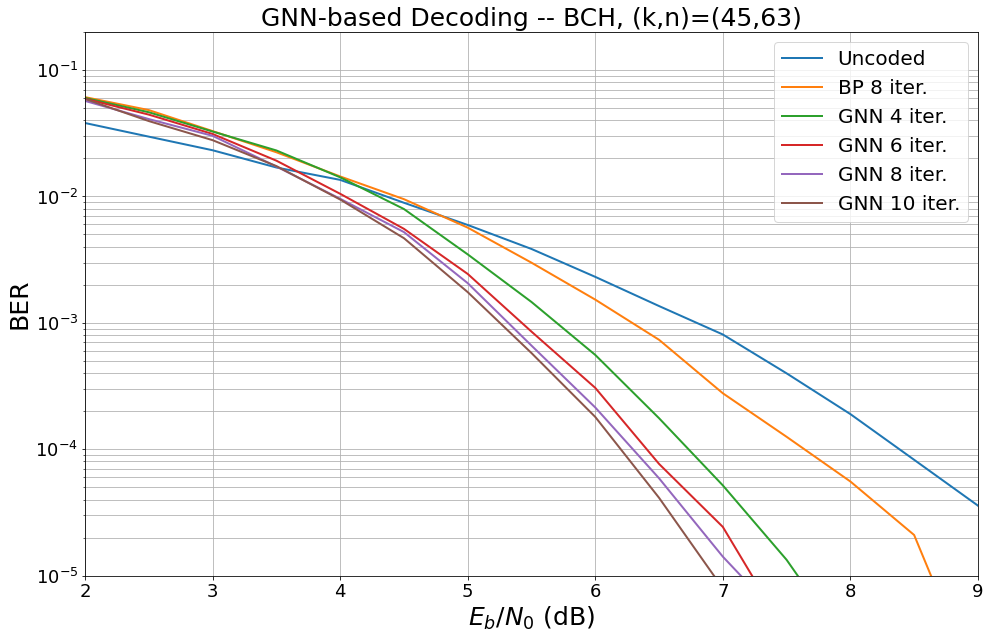

In [23]:
for iters in params["eval_iters"]:
    # instantiate new decoder for each number of iter (otherwise no retracing)
    gnn_dec_eval = GNN_BP(pcm=pcm,
                          num_embed_dims=params["num_embed_dims"],
                          num_msg_dims=params["num_msg_dims"],
                          num_hidden_units=params["num_hidden_units"],
                          num_mlp_layers=params["num_mlp_layers"],
                          num_iter=iters,
                          reduce_op=params["reduce_op"],
                          activation=params["activation"],
                          output_all_iter=False,
                          clip_llr_to=params["clip_llr_to"],
                          use_attributes=params["use_attributes"],
                          node_attribute_dims=params["node_attribute_dims"],
                          msg_attribute_dims=params["msg_attribute_dims"],
                          use_bias=params["use_bias"])    
    # generate new model   
    model_eval = E2EModel(encoder, gnn_dec_eval, k, n)
    model_eval(1,1.) # init model
    # copy weights from trained decoder
    model_eval._decoder.set_weights(gnn_decoder.get_weights())

    # and run the BER simulations
    ber_plot.simulate(model_eval,
                      ebno_dbs=ebno_dbs,
                      batch_size=params["mc_batch_size"],
                      num_target_block_errors=500,
                      legend=f"GNN {iters} iter.",
                      soft_estimates=True,
                      max_mc_iter=params["mc_iters"],
                      forward_keyboard_interrupt=False,
                      show_fig=False);

ber_plot(xlim=[2,9],ylim=[1e-5,0.2]) # show final figure